<a href="https://colab.research.google.com/github/cakennedy/266-mbti-project/blob/main/notebooks/W266MBTIDataLoaders_SJ_1030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Set up 

In [2]:
# Google collab premium utilities status check
# GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print( '\n')

# RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Nov  3 20:00:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
! ls -lrt /content/drive/MyDrive/*.json

-rw------- 1 root root 2308 Oct 13 00:53 /content/drive/MyDrive/nlpproject.json
-rw------- 1 root root 2326 Oct 31 03:37 /content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json


In [4]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json' 
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/drive/MyDrive/pacific-castle-360400-a3ca89f64de6.json


In [5]:
from google.cloud import storage

storage_client = storage.Client()

buckets = storage_client.list_buckets()

print('-- List of buckets in project \"' + storage_client.project + '\"')

for b in buckets:
  print(b.name)

-- List of buckets in project "pacific-castle-360400"
266csffile


In [6]:
!pip install transformers
import os, re
import time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import io
from io import BytesIO
from transformers import AutoTokenizer, TFAutoModel
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score,roc_auc_score,roc_curve,recall_score, precision_score, f1_score,matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.0 MB/s 
     |████████████████████████████████| 163 kB 78.8 MB/s 
     |████████████████████████████████| 7.6 MB 59.0 MB/s 


In [7]:
bert_model_name='bert-base-cased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = TFAutoModel.from_pretrained(bert_model_name)
#bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
#bert_model = TFBertModel.from_pretrained('bert-base-cased')
bert_model.trainable = False



Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Data Prep Training and Validation

In [8]:
max_length=500
batch_size =32

In [9]:
# Checkpoint configurations on google drive 

checkpoint_dir = 'drive/MyDrive/W266/MBTI/model_checkpoints/'
#checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint_filepath = checkpoint_dir + 'bert_cnn.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    #save_freq =100*batch_size
    )

In [10]:
#Initialize google storage
#storage_client = storage.Client.from_service_account_json('pacific-castle-360400-a3ca89f64de6.json')

#Print buckets available
for bucket in storage_client.list_buckets():
  print(bucket)

#Assign bucket name being used
bucket_name = '266csffile'

#Get bucket
bucket = storage_client.get_bucket(bucket_name)

# #Show list of files in bucket and list the files
# filelist = list(bucket.list_blobs(prefix=''))
# for name in filelist:
#   print(name.name)

<Bucket: 266csffile>


In [11]:
def read_parquet_google_cloud(file):
    '''This function reads a file from the google cloud storage bucket. Input
    parameters include the filename, encoding and CSV file separators.'''

    #Load Google Cloud storage client using service key

    blob = bucket.blob(file)
    read_back = bucket.blob(file)
    string_read_back = read_back.download_as_string()
    new_df = pd.read_parquet(io.BytesIO(string_read_back))

    return new_df

In [11]:
train_mbti_data = read_parquet_google_cloud('train_uniform_mbti_data.parquet')
train_mbti_labels = read_parquet_google_cloud('train_uniform_mbti_labels.parquet')

dev_mbti_data = read_parquet_google_cloud('dev_mbti_data.parquet')
dev_mbti_labels = read_parquet_google_cloud('dev_mbti_labels.parquet')

In [12]:
#Create dictonary to transform MBTI type into multiclass value from 0 to 15
valid_MBTI = {'ISTJ': 0, 'INTJ': 1, 'ESTJ': 2, 'ENTJ': 3, 'ENTP': 4, 'INTP': 5, \
              'ISTP': 6, 'ESTP': 7, 'ISFJ': 8, 'INFJ': 9, 'ESFJ': 10, \
              'ENFJ': 11, 'ENFP': 12, 'INFP': 13, 'ISFP': 14, 'ESFP': 15}

In [13]:
def preprocess_data(message,labels,tokenizer,max_length=500):


    encodings = tokenizer(message,truncation=True,max_length=max_length,
                          padding='max_length',return_attention_mask=True,
                          return_token_type_ids=True, return_tensors='tf')

    # Extract encoded features and labels, add to corresponding lists
    input_ids = np.array(encodings["input_ids"], dtype="int32")
    attention_masks = np.array(encodings["attention_mask"], dtype="int32")
    token_type_ids = np.array(encodings["token_type_ids"], dtype="int32")
    np_labels = np.asarray(labels)
    return [input_ids,attention_masks,token_type_ids], np_labels

In [14]:
train_mbti_data, train_mbti_labels = train_mbti_data[:120000], train_mbti_labels[:120000]

In [15]:
# just take 1000 examples for dev validation
dev_mbti_data, dev_mbti_labels = dev_mbti_data[:1000], dev_mbti_labels[:1000]

In [16]:
#Map class for dev 



#Generate data for encodings for dev 

dev_data_st = dev_mbti_data['message'].values.astype(str).tolist()
dev_labels = dev_mbti_labels['MBTI Type'].map(valid_MBTI).values.tolist()


# Generate encodings for dev and test
dev_encodings = bert_tokenizer(dev_data_st,truncation=True, max_length=max_length,padding='max_length',return_attention_mask=True,return_token_type_ids=True, return_tensors='tf')
npdev_labels = np.asarray(dev_labels)


In [14]:
def document_model_run(model_type,mbti_model,target_names,results_dict,input_ids,token_type_ids,attention_mask,nptest_labels):

  score = mbti_model.evaluate([input_ids,token_type_ids,attention_mask],nptest_labels) 
  print('Test loss:', score[0]) 
  print('Test accuracy:', score[1])

  predictions = mbti_model.predict([input_ids,token_type_ids,attention_mask])

  predictions = tf.argmax(predictions, axis=-1)

  predictions = predictions.numpy()

  print(classification_report(nptest_labels, predictions, target_names=target_names))

  cr = classification_report(nptest_labels, predictions, target_names=target_names)

  cm = tf.math.confusion_matrix(nptest_labels, predictions)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(20,16))
  sns.heatmap(
      cm, annot=True,
      xticklabels=target_names,
      yticklabels=target_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")

  results_dict[model_type] = {'model_type': model_type,
                              'cm':cm,
                              'cr':cr,
                              'test_loss': score[0],
                              'test_accuracy': score[1]
                              }

In [55]:
class MBTIDataGenerator(tf.keras.utils.Sequence): 
    def __init__(self,
                 tokenizer,
                 n_examples,
                 df_train,
                 df_labels,
                 max_length=500,
                 batch_size=32,
                 shuffle=True):
        
        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.df_train = df_train
        self.df_labels = df_labels
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        # NOTE: USING REDUCED BATCHES PER EPOCH TO SPEED UP THE LIVE DEMO
        # For normal use, this line should be:
        return self.n_examples // self.batch_size
        #return 1500
    
    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        
        # we cant read the gcs file in batch in parquet mode.... we have to read the entire frame and then
        # pass it to data frame for vectorization in the data loader and continue to loop thorugh that 
        
        message = self.df_train.iloc[batch_start:batch_end]['message'].values.astype(str).tolist()
        
        labels = self.df_labels.iloc[batch_start:batch_end]['MBTI Type'].map(valid_MBTI).values.tolist()
        
        batch_data = preprocess_data(
            message,
            labels,
            self.tokenizer,
            self.max_length
        )

        return batch_data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [56]:
train_data_generator = MBTIDataGenerator(
    tokenizer=bert_tokenizer,
    #n_examples=1200000,
    n_examples=120000,
    df_train=train_mbti_data,
    df_labels=train_mbti_labels,
    max_length=500,
    batch_size=32
)

# BERT + CNN for classification

In [16]:
def create_mbti_bert_train_cnn_model( bert_model,hidden_size = 501, 
                                learning_rate= 0.00005,
                                num_filters = [200,100,75,60,40,25],
                                kernel_sizes = [2,5,8,10,12,16],
                                dropout = 0.3,
                                last_layer_num = 11):
    """
    Build a  classification model with BERT, where you apply CNN layers  to the BERT output
    """


    # Freeze all but the last transformer block of the given bert model
    for w in bert_model.weights:
        if 'layer_._%s' % last_layer_num not in w.name:
            w._trainable = False
    
    #Define the input layer
    input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    #Seprate Bert embeddings, here we pass all the embeddings and not just CLS token or Avg of all, let CNN learn and adjust classification weights from the BERT output
    bert_embeddings = bert_output[0]
    #Generate CNN model layers 
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(bert_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout)(conv_output)

    last_hidden_output = keras.layers.Dense(hidden_size, activation='relu')(last_hidden_output)

    cnn_prediction = keras.layers.Dense(16, activation='softmax')(last_hidden_output)
    #Set the model & Compile it
    classfication_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_masks], outputs=[cnn_prediction])
    classfication_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),  # From information theory notebooks.
                      metrics=['accuracy'])
    
    return classfication_model

In [17]:
mbti_bert_train_cnn_model = create_mbti_bert_train_cnn_model(bert_model)

In [18]:
# step to restore weights from the stored checkpoint 
# this is from epoch 5
mbti_bert_train_cnn_model.load_weights(checkpoint_dir + 'bert_cnn.hdf5')

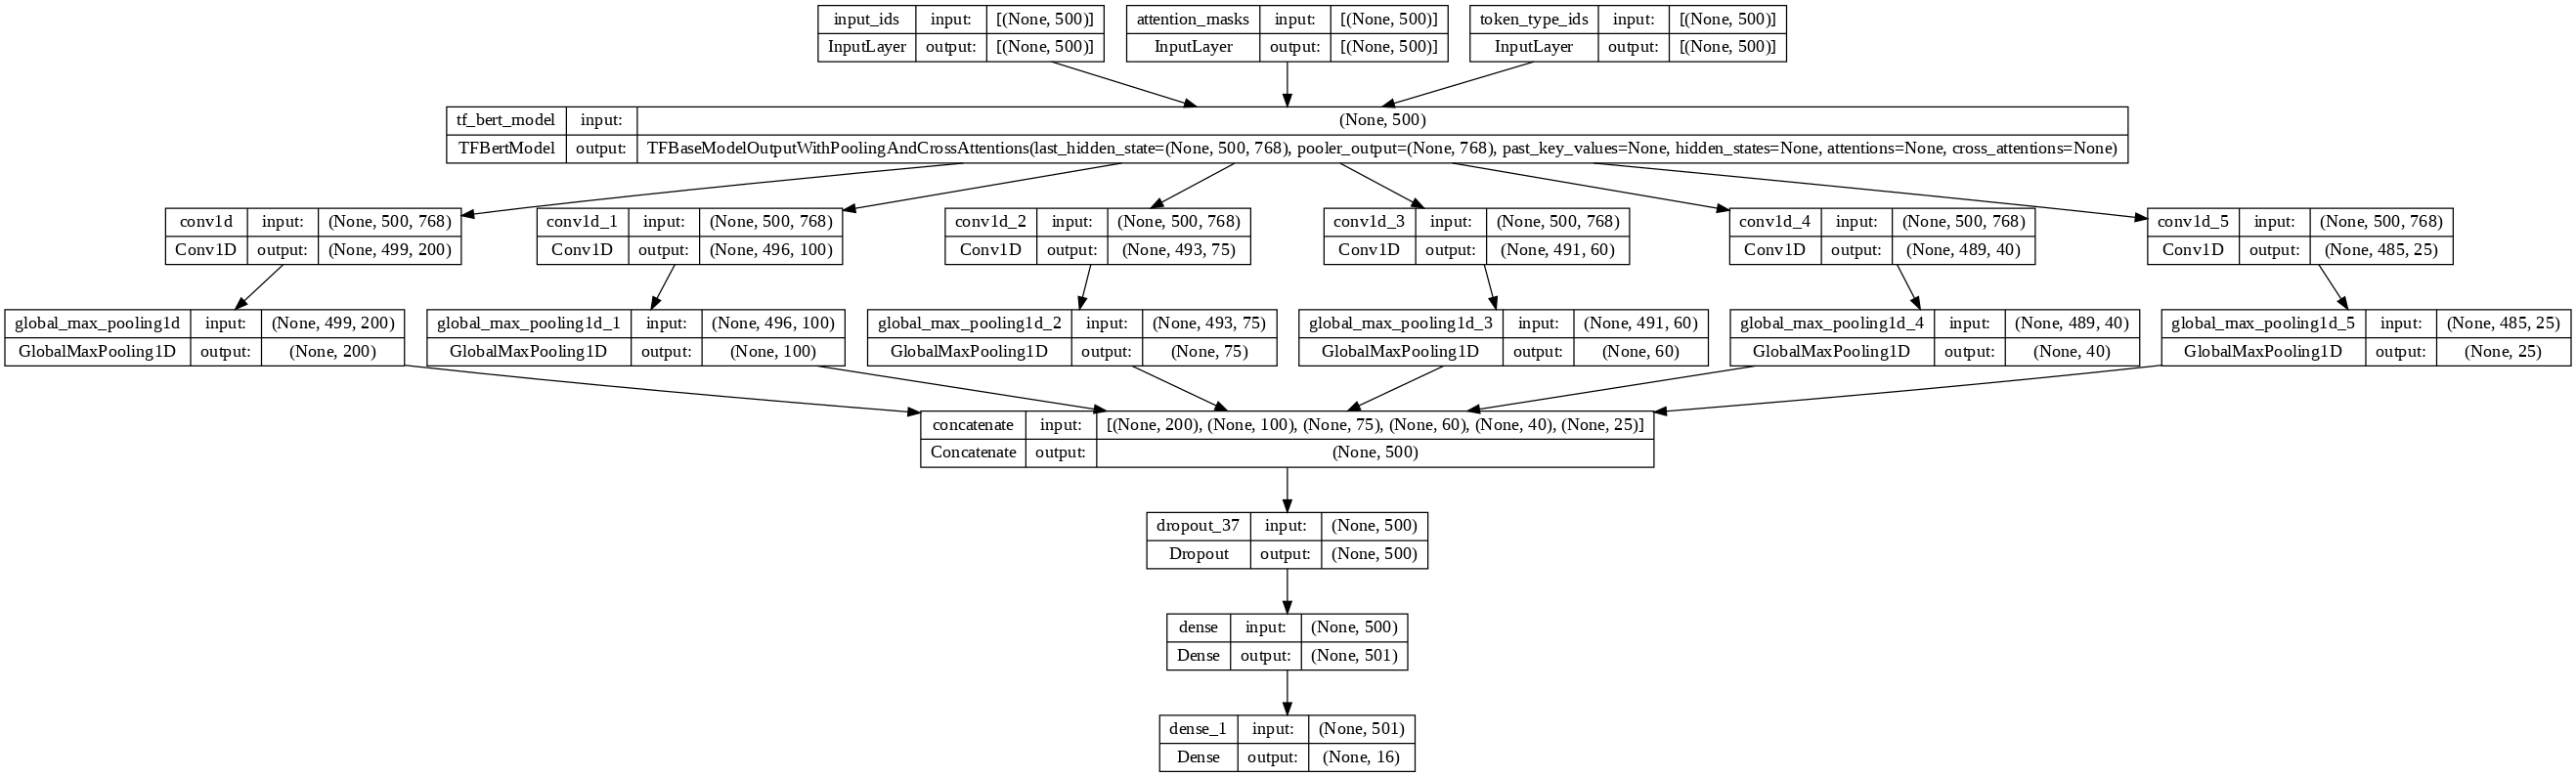

In [59]:
keras.utils.plot_model(mbti_bert_train_cnn_model, show_shapes=True, dpi=90)

In [ ]:
mbti_bert_train_cnn_model_history = mbti_bert_train_cnn_model.fit(train_data_generator,    
                                                  validation_data=([dev_encodings.input_ids,dev_encodings.token_type_ids, dev_encodings.attention_mask],npdev_labels),    
                                                  callbacks=[model_checkpoint_callback],
                                                  epochs=8)

Epoch 1/8
3750/3750 [==============================] - 5691s 2s/step - loss: 2.7856 - accuracy: 0.0683 - val_loss: 2.7625 - val_accuracy: 0.0700
Epoch 2/8
3750/3750 [==============================] - 5691s 2s/step - loss: 2.7711 - accuracy: 0.0746 - val_loss: 2.7575 - val_accuracy: 0.0770
Epoch 3/8
3750/3750 [==============================] - 5692s 2s/step - loss: 2.7647 - accuracy: 0.0805 - val_loss: 2.7760 - val_accuracy: 0.0570
Epoch 4/8
3750/3750 [==============================] - 5688s 2s/step - loss: 2.7564 - accuracy: 0.0858 - val_loss: 2.7646 - val_accuracy: 0.0790
Epoch 5/8
3750/3750 [==============================] - 5690s 2s/step - loss: 2.7463 - accuracy: 0.0947 - val_loss: 2.7744 - val_accuracy: 0.0660
Epoch 6/8
 105/3750 [..............................] - ETA: 1:31:33 - loss: 2.7319 - accuracy: 0.1012

## Load failed because of google colab+ limitation at 6th epoch

# Set up test and document the run

In [19]:
results_dict={}

In [20]:
test_mbti_data = read_parquet_google_cloud('test_mbti_data.parquet')
test_mbti_labels = read_parquet_google_cloud('test_mbti_labels.parquet')


In [21]:
 test_mbti_data, test_mbti_labels = test_mbti_data[:1000], test_mbti_labels[:1000]

In [22]:

test_labels = test_mbti_labels['MBTI Type'].map(valid_MBTI).values.tolist()
test_data_st = test_mbti_data['message'].values.astype(str).tolist()

# Generate encodings for dev and test
test_encodings = bert_tokenizer(test_data_st,truncation=True, max_length=max_length,padding='max_length',return_attention_mask=True,return_token_type_ids=True, return_tensors='tf')

nptest_labels = np.asarray(test_labels)

32/32 [==============================] - 49s 1s/step - loss: 2.7806 - accuracy: 0.0690
Test loss: 2.780606508255005
Test accuracy: 0.0689999982714653
32/32 [==============================] - 47s 1s/step
              precision    recall  f1-score   support

        ISTJ       0.01      0.05      0.02        21
        INTJ       0.25      0.01      0.01       137
        ESTJ       0.18      0.08      0.11        26
        ENTJ       0.00      0.00      0.00        43
        ENTP       0.11      0.01      0.02        78
        INTP       0.33      0.01      0.01       139
        ISTP       0.05      0.19      0.07        43
        ESTP       0.00      0.00      0.00        27
        ISFJ       0.00      0.00      0.00        20
        INFJ       0.12      0.34      0.18       112
        ESFJ       0.04      0.12      0.06        24
        ENFJ       0.00      0.00      0.00        29
        ENFP       0.33      0.04      0.08       112
        INFP       0.00      0.00      0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

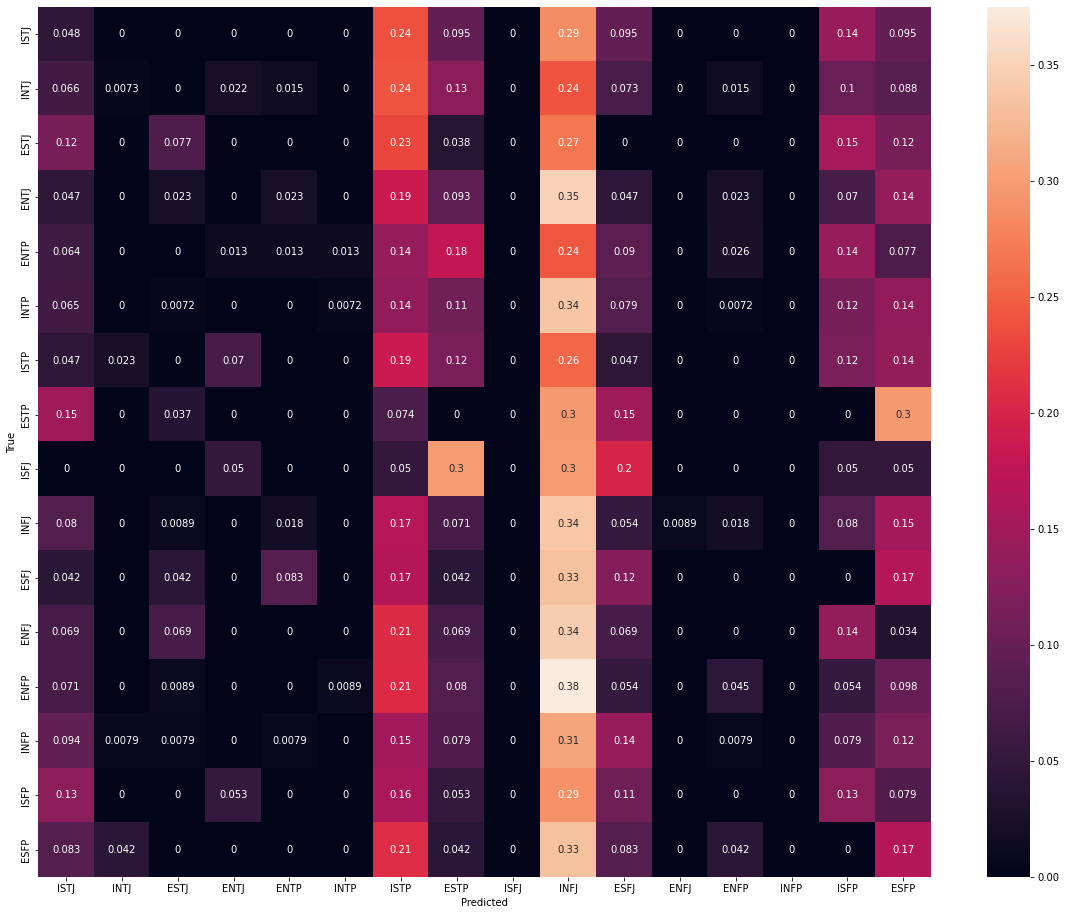

In [22]:
document_model_run('mbti_bert_train_cnn_model',
                   mbti_bert_train_cnn_model,
                   valid_MBTI,results_dict,
                   test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
                   nptest_labels)

In [23]:


results_filepath = checkpoint_dir + 'bert_cnn_results.txt'
f = open(results_filepath,"w")

# write file
f.write( str(results_dict) )

# close file
f.close()


# Commented out code

In [ ]:
# def create_mbti_bert_clstoken_model(bert_model,hidden_size = 501, 
#                                 dropout=0.3,
#                                 learning_rate=0.00005):
#     """
#     Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
#     """
#     #Define the input layer
#     input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
#     attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
#     token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')

#     bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)   

#     #Get CLS token vector representation , CLS is at 0th position
#     cls_token = bert_output[0][:,  0, :]

#     hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

#     hidden = tf.keras.layers.Dropout(dropout)(hidden)  

#     classification = tf.keras.layers.Dense(16, activation='sigmoid',name='classification_layer')(hidden)
    
#     classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_masks], outputs=[classification])
    
#     classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), 
#                                  #metrics=['sparse_categorical_accuracy']
#                                  metrics=['accuracy'])
#     return classification_model

In [ ]:
# mbti_bert_clstoken_model = create_mbti_bert_clstoken_model(bert_model)

In [ ]:
# keras.utils.plot_model(mbti_bert_clstoken_model, show_shapes=True, dpi=90)

In [ ]:
# mbti_bert_clstoken_model_history = mbti_bert_clstoken_model.fit(train_data_generator,    
#                                                   validation_data=([dev_encodings.input_ids,dev_encodings.token_type_ids, dev_encodings.attention_mask],npdev_labels),    
#                                                   callbacks=[model_checkpoint_callback],
#                                                   epochs=2)

In [ ]:
# document_model_run('mbti_bert_clstoken_model',
#                    mbti_bert_clstoken_model,
#                    valid_MBTI,results_dict,
#                    test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
#                    nptest_labels)

In [ ]:
# #first model run with key_dim =500
# document_model_run('mbti_bert_train_cnn_model',
#                    mbti_bert_model,
#                    valid_MBTI,results_dict,
#                    test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
#                    nptest_labels)

In [ ]:
# # this one is based on the multiheaded attention added 
# def create_mbti_bert_model(bert_model,
#                                 hidden_size = 501, 
#                                 dropout=0.3,
#                                 learning_rate=0.00005,max_length=500):
#     """
#     Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
#     """

#     input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
#     attention_masks = layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_masks')
#     token_type_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids')
  
#     bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
#     sequence_output = bert_output.last_hidden_state

#     #attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=100)(sequence_output, sequence_output)
#     #Fix 1 increasing key dim to match the max length  
#     attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=500)(sequence_output, sequence_output)
#     max_pool = layers.GlobalMaxPooling1D()(attn_output)
#     dropout_output = layers.Dropout(0.3)(max_pool)
#     final_output = layers.Dense(16, activation="softmax")(dropout_output)
    
#     model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
#                                   outputs=[final_output])
#     model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

In [ ]:
# mbti_bert_model = create_mbti_bert_model(bert_model)

In [ ]:
# mbti_bert_model.summary()

In [ ]:
# keras.utils.plot_model(mbti_bert_model, show_shapes=True, dpi=90)

In [ ]:
# mbti_batch_bert_clstoken_model_history = mbti_bert_clstoken_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask], 
#                                                   nptrain_labels,   
#                                                   validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask], 
#                                                   npvalid_labels),    
#                                                   batch_size=32, 
#                                                   epochs=2)

In [ ]:
# mbti_batch_bert_model_history = mbti_bert_model.fit(train_data_generator,    
#                                                   validation_data=([dev_encodings.input_ids,dev_encodings.token_type_ids, dev_encodings.attention_mask],npdev_labels),    
#                                                   # callbacks=[model_checkpoint_callback],
#                                                   epochs=2)


In [ ]:
# #first model run with key_dim =500
# document_model_run('mbti_bert_model_key_dim_500',
#                    mbti_bert_model,
#                    valid_MBTI,results_dict,
#                    test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
#                    nptest_labels)

In [ ]:

# document_model_run('mbti_bert_model',
#                    mbti_bert_model,
#                    valid_MBTI,results_dict,
#                    test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
#                    nptest_labels)

In [ ]:
# mbti_batch_bert_model_history = mbti_bert_model.fit(train_data_generator,    
#                                                   validation_data=([dev_encodings.input_ids,dev_encodings.token_type_ids, dev_encodings.attention_mask],npdev_labels),    
#                                                   callbacks=[model_checkpoint_callback],
#                                                   epochs=2)


In [ ]:
# mbti_bert_model.save_weights(checkpoint_dir.format(epoch=2))

In [ ]:
# results_dict.values()

In [ ]:
# mbti_bert_model.summary()

In [ ]:
document_model_run('mbti_bert_train_cnn_model',
                   mbti_bert_train_cnn_model,
                   valid_MBTI,results_dict,
                   test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask,
                   nptest_labels)

In [23]:
  predictions = mbti_bert_train_cnn_model.predict([test_encodings.input_ids,test_encodings.token_type_ids,test_encodings.attention_mask])

  predictions = tf.argmax(predictions, axis=-1)

  predictions = predictions.numpy()

32/32 [==============================] - 43s 1s/step


In [36]:
correct_classifications = list(np.where(nptest_labels == predictions))

In [37]:
type(correct_classifications)

list

In [29]:
correct_classifications[2]

IndexError: ignored

In [ ]:
test_mbti_data, test_mbti_labels

In [45]:
for i in correct_classifications:
  print (i)

[  0   2   4  22  23  38  48  51  93 115 119 154 160 167 170 184 196 223
 227 232 252 257 271 277 293 298 329 351 353 373 375 388 393 405 406 438
 444 454 459 464 503 506 515 522 523 560 565 605 614 660 662 663 669 684
 686 705 712 734 750 784 791 797 836 846 851 907 910 938 953]


In [40]:
for i in correct_classifications:
  message_length = len(test_data_st[i].split())
  print (i,message_length)

TypeError: ignored

In [44]:
len(test_data_st[2].split())

61

In [44]:
len(test_mbti_data.iloc[2]['message'].split())

61

In [49]:
correct ={}
wrong={}
correct['mbti_bert_train_cnn_model'] = np.where(nptest_labels == predictions)
wrong['mbti_bert_train_cnn_model'] = np.where(nptest_labels != predictions)

In [68]:
wrong['mbti_bert_train_cnn_model'][0]

array([  1,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  49,  50,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 168, 169,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 19

In [71]:
print('mean',np.mean([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in correct['mbti_bert_train_cnn_model'][0]]))

mean 94.2463768115942
min 0
max 794


In [72]:
print('mean',np.mean([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))
print('min',np.min([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))
print('max',np.max([len(test_data_st[i].split()) for i in wrong['mbti_bert_train_cnn_model'][0]]))

mean 82.59720730397422
min 0
max 3163


In [70]:
len(test_data_st[100].split())

260

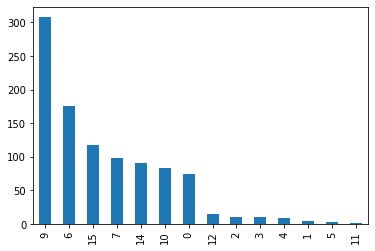

In [47]:
pd.Series(predictions).value_counts().plot(kind = 'bar')

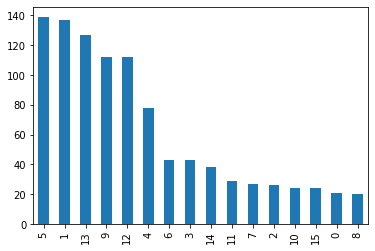

In [46]:
pd.Series(nptest_labels).value_counts().plot(kind = 'bar')

# Notes and Next Steps

Tactial Portion


a)  not much improvment after 5 epochs but better than 2 epochs , it is really about how far we can run this I guess

b) another approach is to add multiheaded self attention on the BERT. @john in your code I think you added 16 heads but I guess thats too many we can try with 6 or 8 may be

c) Current CNN filter sizes are random guess ..need to look into how can we make them better  

d) Is 500 max length ... too much. @SJ will see in above model at message length we got the right output 

e) should we convert document run function from dictionary to pandas data frame ..minor point in big scheme of things

f) I cut down train data size to 120000.. even then with batch size of 32 and one epoch it takes about 1:20 mins or so.. are there ways to make this faster. W251 was resource intensive and instructors gave guidance as well as processing capabilities needs for each home work as well as for project based on scope, here I guess I am doing something basic wrong which is adding more processing time , please review 

g) dataloaders - current implementation of data loaders is not most efficient one. If there is a way to convert source files into CSV(based on what I know) then we can utilize the skiprows option while data gets into the dataframe, with parquet format I could not get that working with pyarrow, so somewhat of a round about way of implementing this. but then with CSV the load times will be larger as it is not compressed as compared to parquet.. I dont think this would matter much to the grade but if either of you have bandwidth of experience on tuning this further please look into this.



h) overall for BERT I think we have 2 options 

a) Unfreeze a layer and train it for our data set and then add CNN on top (which I have done here) 

b) Keep BERT as it is and then add multiheaded self attention layer (code is in this notebook but did not yield much results either)

but i believe this a good topic to dig further into for BERT section of our report and showcase the differences 

